In [ ]:
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d

In [2]:
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Merge,Flatten,Dropout
from keras.layers import Conv1D,Reshape
import keras

# For the plots 
import matplotlib.pyplot as plt

# For controlling the training parameters in the midst of training itself
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# For creating directory to save the models
import os
from imblearn.over_sampling import SMOTE



In [288]:
# Load the data
X = np.load("X (1).npy")
Y = np.load("Y (1).npy")

XT = np.column_stack( (X,Y) )
YT = []
for y in Y:
    if y==0:
        YT.append(0)
    else:
        YT.append(1)
#     elif y>0 and y<=50:
#         YT.append(1)
#     elif y>50 and y<=100:
#         YT.append(2)
#     elif y>100 and y<=150:
#         YT.append(3)
#     elif y>150 and y<=200:
#         YT.append(4)
        
YT = np.array(YT)

In [264]:
# Split the test train and pass it into validation
from sklearn.utils import class_weight

X_train, X_test, Y_train, Y_test = train_test_split(XT, YT, test_size=0.2, random_state=12)
# class_weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

sm = SMOTE(random_state=12, ratio = 1.0, k_neighbors = 5)
x_res, y_res = sm.fit_sample(X_train, Y_train)
# print (Y_train.value_counts(), np.bincount(y_res))
# weights = np.array(class_weight)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [265]:
# X_train = x_res[:,:100]
X_train, X_test, Y_train, Y_test = train_test_split(XT, YT, test_size=0.2, random_state=12)

In [10]:
X_test = np.load("newX_test.npy")

Y_test = np.load("newY_test.npy")

X_train = np.load("newX_train.npy")

Y_train = np.load("newY_train.npy")


In [14]:
# Reshape the stuff according to the the shape Keras expects it to be !
# data_lstm = x_res[:,:100].reshape((x_res[:,:100].shape[0], 100, 1))
# Y_train = x_res[:,-1]
# target = np.round(Y_train.reshape((Y_train.shape[0], 1)))
# target = Y_train

data_lstm = X_train[:,:100].reshape((X_train[:,:100].shape[0], 100, 1))
val_data_lstm = X_test[:,:100].reshape(X_test[:,:100].shape[0],100,1)
target = Y_train.reshape(Y_train.shape[0],1)
val_target = Y_test.reshape(Y_test.shape[0],1)
data_mw = X_train[:,-1].reshape((X_train[:,-1].shape[0],1))
val_data_mw = X_test[:,-1].reshape((X_test[:,-1].shape[0],1))
# val_target = Y_test

In [267]:
# data_mw = x_res[:,-2].reshape((x_res[:,-2].shape[0],1))
# val_data_mw = X_test[:,-2].reshape((X_test[:,-2].shape[0],1))

In [12]:
val_data_mw.shape

(515, 1)

In [15]:
max(target)

array([199])

In [214]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [16]:
branch1 = Sequential()

branch1.add(Conv1D(2,3,activation='tanh',input_shape=(100, 1)))
branch1.add(Conv1D(4,3,activation='tanh'))
branch1.add(Conv1D(6,3,activation='tanh'))
branch1.add(Dropout(0.2))
branch1.add(Conv1D(8,3,activation='tanh'))
branch1.add(Conv1D(10,3,activation='tanh'))
branch1.add(Flatten())
branch1.add(Dense(10))




branch2 = Sequential()
branch2.add(Dense(10,input_dim=1))
branch2.add(Dense(10,activation='tanh'))
            
            
model =Sequential()
model.add(Merge([branch1, branch2], mode = 'concat'))
model.add(Dense(1,activation='relu'))
# branch1.add(Dropout(0.4))
model.add(Dense(1,activation='relu'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [19]:
# Define the output for the saving the checkpoint (best models)

outputFolder = './output-cnn'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/Weights-{epoch:02d}-{val_acc:.2f}.hdf5"

In [27]:
# The callback function for model checkpoint saving
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True,\
                             save_weights_only=True,mode='auto')

# The callback function for earlystopping

earlystop = EarlyStopping(monitor='val_loss',patience=10, \
                          verbose=1, mode='auto')

# The callback function for reducing learning rate on plateus

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001)

In [28]:
# Put all those calback in a list
callbacks = [earlystop, reduce_lr]
# callbacks = [checkpoint, reduce_lr]

In [37]:
# I have decided to use mean_absolute_error , beacuse for some reason mean squared e
#weighted_categorical_crossentropy(weights)
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['accuracy'])
model_info = model.fit([data_lstm,data_mw], target, epochs=1000, batch_size=100, verbose=2,validation_data=([val_data_lstm,val_data_mw],val_target)
                      )#,callbacks=callbacks)#, class_weight=class_weight)

Train on 2495 samples, validate on 515 samples
Epoch 1/1000
1s - loss: 28.2631 - acc: 0.0457 - val_loss: 58.1055 - val_acc: 0.0058
Epoch 2/1000
0s - loss: 27.7921 - acc: 0.0445 - val_loss: 53.6087 - val_acc: 0.0039
Epoch 3/1000
0s - loss: 26.1455 - acc: 0.0477 - val_loss: 55.6444 - val_acc: 0.0058
Epoch 4/1000
0s - loss: 27.1985 - acc: 0.0461 - val_loss: 53.8538 - val_acc: 0.0058
Epoch 5/1000
0s - loss: 27.3018 - acc: 0.0461 - val_loss: 54.3805 - val_acc: 0.0039
Epoch 6/1000
0s - loss: 27.0124 - acc: 0.0465 - val_loss: 54.4339 - val_acc: 0.0039
Epoch 7/1000
0s - loss: 26.5420 - acc: 0.0457 - val_loss: 52.8556 - val_acc: 0.0039
Epoch 8/1000
0s - loss: 27.5499 - acc: 0.0453 - val_loss: 54.4482 - val_acc: 0.0039
Epoch 9/1000
0s - loss: 26.3687 - acc: 0.0465 - val_loss: 58.4621 - val_acc: 0.0039
Epoch 10/1000
0s - loss: 27.9494 - acc: 0.0477 - val_loss: 61.2670 - val_acc: 0.0058
Epoch 11/1000
0s - loss: 27.2563 - acc: 0.0461 - val_loss: 57.3258 - val_acc: 0.0039
Epoch 12/1000
0s - loss: 26

KeyboardInterrupt: 

In [161]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

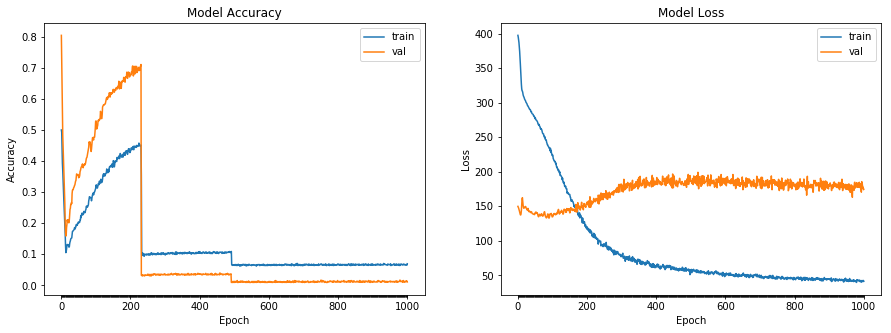

In [287]:
plot_model_history(model_info)

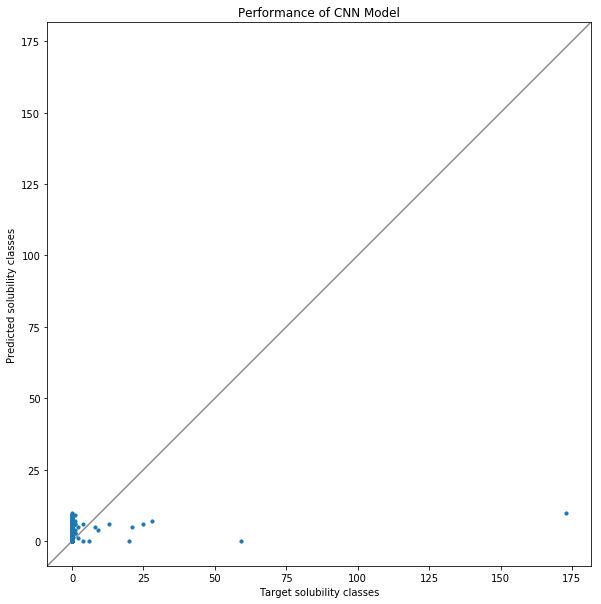

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(val_target,np.round(model.predict([val_data_lstm,val_data_mw])), s= 10)
plt.xlabel('Target solubility classes')
plt.ylabel('Predicted solubility classes')
plt.title('Performance of CNN Model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.45, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [247]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(val_target, np.round(model.predict([val_data_lstm,val_data_mw])))

In [71]:
print(np.round(model.predict([val_data_lstm,val_data_mw])))

[[  0.]
 [ 39.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  4.]
 [  0.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  5.]
 [  0.]
 [  8.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  2.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 27.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  1.]
 [  5.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  1.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 30.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 27.]
 [  0.]
 [ 12.]
 [  0.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  2.]
 [  0.]
 [  0.]
 [ 18.]
 [  1.]
 [  0.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 39.]
 [  0.]
 [ 39.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 15.]
 [  0.]
 [ 28.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]


In [248]:
mse*19/200

0.026161538461538462

In [231]:
mean_squared_error(target,np.round(model.predict([data_lstm,data_mw])))*19/200

0.31245809386973183

In [232]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(val_target, np.round(model.predict([val_data_lstm,val_data_mw]))
                                               ,average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.017035012364961605, 0.059999999999999998, 0.013816007208978456, None)